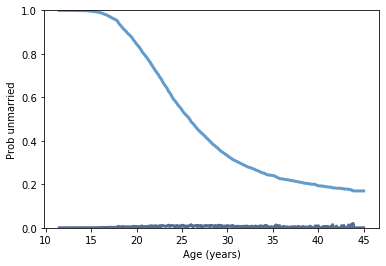

In [13]:
from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import numpy as np
import pandas as pd

import random

import thinkstats2
import thinkplot
import nsfg
import survival
from collections import Counter

#First cell sets up functions that will be needed for exercise.
#Reading nsfg response data
resp6 = nsfg.ReadFemResp()

#Got from solution code. Cleaning up responses for marriage. Pg 170 cmmarrhx is the date the repsondent was first married, if applicable and known
resp6.cmmarrhx.replace([9997, 9998, 9999], np.nan, inplace=True)
resp6['agemarry'] = (resp6.cmmarrhx - resp6.cmbirth) / 12.0
resp6['age'] = (resp6.cmintvw - resp6.cmbirth) / 12.0

#Extract ages for either people who are married or the age of person at interview who are not married.
complete = resp6[resp6.evrmarry==1].agemarry.dropna()
ongoing = resp6[resp6.evrmarry==0].age

#Create estimate hazard function. Pg 169 gives information on Kaplan-Meier
def EstimateHazardFunction(complete, ongoing, label='', verbose=False):
    if np.sum(np.isnan(complete)):
        raise ValueError("complete contains NaNs")
    if np.sum(np.isnan(ongoing)):
        raise ValueError("ongoing contains NaNs")

    hist_complete = Counter(complete)
    hist_ongoing = Counter(ongoing)

    ts = list(hist_complete | hist_ongoing)
    ts.sort()

    at_risk = len(complete) + len(ongoing)

    lams = pd.Series(index=ts)
    for t in ts:
        ended = hist_complete[t]
        censored = hist_ongoing[t]

        lams[t] = ended / at_risk
        if verbose:
            print(t, at_risk, ended, censored, lams[t])
        at_risk -= ended + censored

    return survival.HazardFunction(lams, label=label)

#Plot hazard function
hf = EstimateHazardFunction(complete, ongoing)
thinkplot.Plot(hf)
thinkplot.Config(xlabel='Age (years)',
                 ylabel='Hazard')

#Plot the survival function
sf = hf.MakeSurvival()
thinkplot.Plot(sf)
thinkplot.Config(xlabel='Age (years)',
                 ylabel='Prob unmarried',
                 ylim=[0, 1])

In [14]:
#Estimating the survival curve. This will return both hazard function and survival function
def EstimateMarriageSurvival(resp):
    complete = resp[resp.evrmarry == 1].agemarry.dropna()
    ongoing = resp[resp.evrmarry == 0].age

    hf = EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

In [22]:
#Got this code from solution code. It's cleaning up the data from responses
def CleanData(resp):
    resp.cmdivorcx.replace([9998, 9999], np.nan, inplace=True)

    resp['notdivorced'] = resp.cmdivorcx.isnull().astype(int)
    resp['duration'] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0
    resp['durationsofar'] = (resp.cmintvw - resp.cmmarrhx) / 12.0

    month0 = pd.to_datetime('1899-12-15')
    dates = [month0 + pd.DateOffset(months=cm) 
             for cm in resp.cmbirth]
    resp['decade'] = (pd.DatetimeIndex(dates).year - 1900) // 10
    
#Creating variable for cycle 6 and cycle 7
resp6 = survival.ReadFemResp2002()
resp7 = survival.ReadFemResp2010()

#Combining cycles into one larger dataset
resps = [resp6, resp7]

In [16]:
#Creating variable for the two different cycles 6 and 7
CleanData(resp6)
married6 = resp6[resp6.evrmarry==1]

CleanData(resp7)
married7 = resp7[resp7.evrmarry==1]

In [17]:
#Resampling the data per exercise request. We're plotting the divorce curve by decade
def ResampleDivorceCurve(resps):
    for _ in range(11):
        samples = [thinkstats2.ResampleRowsWeighted(resp) 
                   for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        PlotDivorceCurveByDecade(sample, color='#225EA8', alpha=0.1)

    thinkplot.Show(xlabel='years',
                   axis=[0, 28, 0, 1])

In [18]:
#Pg 173-174 talks about cohorts. For this we're plotting the divorce curve by each cohort. 
def ResampleDivorceCurveByDecade(resps):
    for i in range(41):
        samples = [thinkstats2.ResampleRowsWeighted(resp) 
                   for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby('decade')
        if i == 0:
            survival.AddLabelsByDecade(groups, alpha=0.7)

        EstimateSurvivalByDecade(groups, alpha=0.1)

    thinkplot.Config(xlabel='Years',
                     ylabel='Fraction undivorced',
                     axis=[0, 28, 0, 1])

In [19]:
#Grouping respondents into decades per exercise request. Then plotting survival curve
def EstimateSurvivalByDecade(groups, **options):
    thinkplot.PrePlot(len(groups))
    for name, group in groups:
        _, sf = EstimateSurvival(group)
        thinkplot.Plot(sf, **options)

In [20]:
#Estimating the surival curve by respondents. Looking at divorces and ongoing marriages.
def EstimateSurvival(resp):
    complete = resp[resp.notdivorced == 0].duration.dropna()
    ongoing = resp[resp.notdivorced == 1].durationsofar.dropna()

    hf = survival.EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

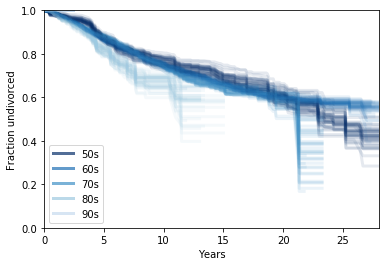

In [21]:
#Looking at both cycles of marriages
ResampleDivorceCurveByDecade([married6, married7])